#%%[markdown]

 # Neural ODE framework with mixture of experts
## Summary
 - We have a multiple dynamical systems that we want to learn
 - We first learn the neural on trajectories from both attractors (initialisation)
 - We then relearn on a single attrator
 - Does it unlearn the other attractor ?

In [ ]:
#%%

import jax

print("\n############# Neural ODE #############\n")
print("Available devices:", jax.devices())

from jax import config
##  Debug nans
config.update("jax_debug_nans", True)

import jax.numpy as jnp
import jax.scipy as jsp
import jax.scipy.optimize

import numpy as np
from scipy.integrate import solve_ivp

import equinox as eqx

import matplotlib.pyplot as plt

from graphpint.utils import *
from graphpint.integrators import *

import optax
from functools import partial
import time


############# Neural ODE #############

Available devices: [cuda(id=0)]


In [ ]:
#%%

# SEED = 27
SEED = 2024

## Integrator hps
integrator = rk4_integrator
# integrator = dopri_integrator

## Optimiser hps
init_lr = 1e-3
decay_rate = 0.9

## Training hps
print_every = 5000
nb_epochs = 100000
# batch_size = 128*10

skip = 100

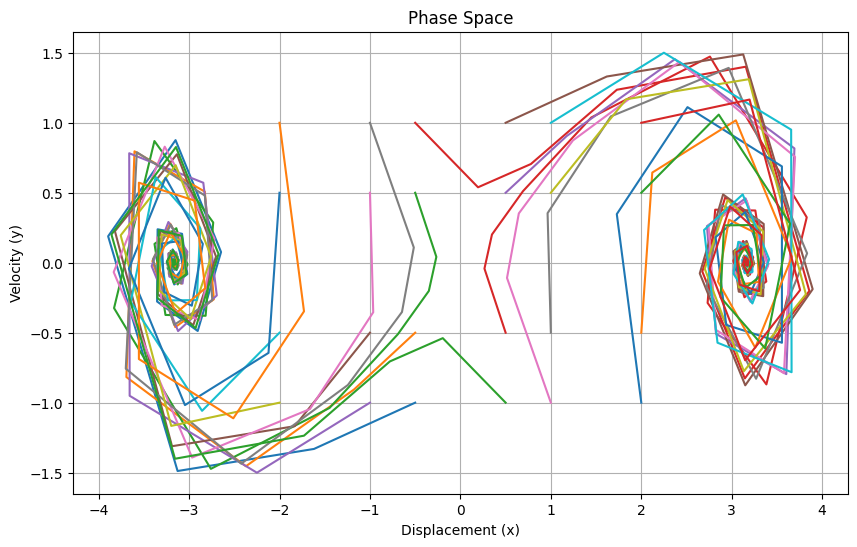

In [ ]:
#%%

# Define the Duffing system
def duffing(t, state, a, b, c):
    x, y = state
    dxdt = y
    dydt = a*y - x*(b + c*x**2)
    return [dxdt, dydt]

# Parameters
a, b, c = -1/2., -1, 1/10.

t_span = (0, 40)
t_eval = np.arange(t_span[0], t_span[1], 0.01)[::skip]


plt.figure(figsize=(10, 6))

init_conds = np.array([[-0.5, -1], [-0.5, -0.5], [-0.5, 0.5], 
                    #    [-1.5, 1], 
                       [-0.5, 1], 
                       [-1, -1], [-1, -0.5], [-1, 0.5], [-1, 1], 
                       [-2, -1], [-2, -0.5], [-2, 0.5], [-2, 1],
                       [0.5, -1], [0.5, -0.5], [0.5, 0.5], [0.5, 1],
                       [1, -1], [1, -0.5], [1, 0.5], [1, 1],
                       [2, -1], [2, -0.5], [2, 0.5], [2, 1],
                       ])


train_data = []

for state0 in init_conds:
    sol = solve_ivp(duffing, t_span, state0, args=(a, b, c), t_eval=t_eval)
    train_data.append(sol.y.T)

    ## Plot the phase space
    plt.plot(sol.y[0], sol.y[1])
    plt.xlabel('Displacement (x)')
    plt.ylabel('Velocity (y)')
    plt.title('Phase Space')
    plt.grid(True)

plt.show()

## Save the training data
data = np.stack(train_data)[None, ...]

In [ ]:
# %%

class Processor(eqx.Module):
    layers: list
    # physics: jnp.ndarray

    def __init__(self, in_size=2, out_size=2, key=None):
        keys = get_new_key(key, num=3)
        # self.layers = [eqx.nn.Linear(in_size, 10, key=keys[0]), jax.nn.tanh,
        self.layers = [eqx.nn.Linear(in_size, 64, key=keys[0]), jax.nn.softplus,
                        eqx.nn.Linear(64, 64, key=keys[1]), jax.nn.softplus,
                        eqx.nn.Linear(64, 64, key=keys[1]), jax.nn.softplus,
                        eqx.nn.Linear(64, out_size, key=keys[2]) ]

        # self.physics = jnp.array([1.5, 1.0, 3.0, 1.0])
        # self.physics = jnp.abs(jax.random.normal(keys[1], (3,)))
        # a = jax.random.uniform(keys[0], (1,), minval=-0.55, maxval=-0.45)[0]
        # b = jax.random.uniform(keys[1], (1,), minval=-1.05, maxval=-0.95)[0]
        # c = jax.random.uniform(keys[2], (1,), minval=0.05, maxval=0.15)[0]
        # self.physics = jnp.array([a, b, c])

    def __call__(self, x, t):
        # x, y = x
        # a, b, c = self.physics
        # ## Physics contribution for duffin system
        # dx = y
        # dy = a*y - x*(b + c*x**2)
        # return jnp.array([dx, dy])

        ## Physics contribution
        # dx0 = x[0]*self.physics[0] - x[0]*x[1]*self.physics[1]
        # dx1 = x[0]*x[1]*self.physics[2] - x[1]*self.physics[3]
        # return jnp.array([dx0, dx1])

        # ## Neural Net contribution
        # # y = jnp.concatenate([jnp.broadcast_to(t, (1,)), x], axis=0)
        y = x
        for layer in self.layers:
            y = layer(y)
        return y

In [ ]:
# %%

model_keys = get_new_key(SEED, num=2)
model = Processor(in_size=2, out_size=2, key=model_keys[0])


params, static = eqx.partition(model, eqx.is_array)
params_flat, params_shapes, tree_def = flatten_pytree(params)

In [ ]:
# %%

def params_norm(params):
    return jnp.array([jnp.sum(jnp.abs(x)) for x in jax.tree_util.tree_leaves(params)]).sum()

def l2_norm(X, X_hat):
    total_loss = jnp.mean((X - X_hat)**2, axis=-1)   ## Norm of d-dimensional vectors
    return jnp.sum(total_loss) / (X.shape[-2])



=== Beginning Training ... ===

Compiling function "train_step" ...


Compiling function "loss_fn" ...

    Epoch:     0      Loss: 333.72561646
    Epoch:     1      Loss: 127.92168427
    Epoch:     2      Loss: 52.09709167
    Epoch:     3      Loss: 19.88026619
    Epoch:  5000      Loss: 0.02987368
    Epoch: 10000      Loss: 0.05327539
    Epoch: 15000      Loss: 0.00047873
    Epoch: 20000      Loss: 0.00016504
    Epoch: 25000      Loss: 0.00009580
    Epoch: 30000      Loss: 0.00004966
    Epoch: 35000      Loss: 0.00001147
    Epoch: 40000      Loss: 0.00001492
    Epoch: 45000      Loss: 0.00002139
    Epoch: 50000      Loss: 0.00000397
    Epoch: 55000      Loss: 0.00000432
    Epoch: 60000      Loss: 0.00000236
    Epoch: 65000      Loss: 0.00000293
    Epoch: 70000      Loss: 0.00000209
    Epoch: 75000      Loss: 0.00000167
    Epoch: 80000      Loss: 0.00000179
    Epoch: 85000      Loss: 0.00002277
    Epoch: 90000      Loss: 0.00000179
    Epoch: 95000      Loss: 0.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Total GD training time: 0 hours 27 mins 23 secs


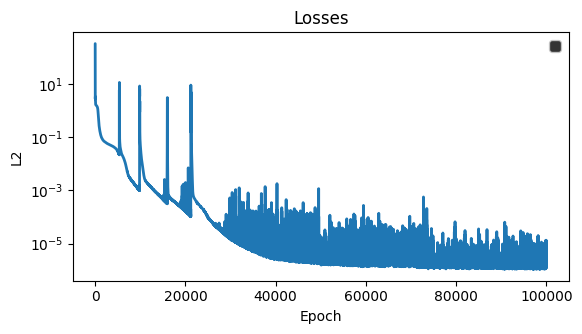

In [ ]:
# %%

### ==== Vanilla Gradient Descent optimisation ==== ####

def loss_fn(params, static, batch):
    print('\nCompiling function "loss_fn" ...\n')
    X, t = batch

    rhs = eqx.combine(params, static)

    # X_hat = integrator(rhs, X[0, 0, :], t, 1.4e-8, 1.4e-8, jnp.inf, jnp.inf, 50, "checkpointed")
    X_hat = jax.vmap(integrator, in_axes=(None, 0, None, None, None, None, None, None, None)
                     )(rhs, X[:, 0, :], t, 1.4e-8, 1.4e-8, jnp.inf, jnp.inf, 50, "checkpointed")

    return jnp.mean((X-X_hat)**2)
    # return l2_norm(X, X_hat)
    # return 1e0*params_norm(params_env)
    # return l2_norm(X, X_hat) + 1e-0*params_norm(params_env)


@partial(jax.jit, static_argnums=(1))
def train_step(params, static, batch, opt_state):
    print('\nCompiling function "train_step" ...\n')

    loss, grads = jax.value_and_grad(loss_fn)(params, static, batch)

    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    return params, opt_state, loss


total_steps = nb_epochs

# sched = optax.exponential_decay(init_lr, total_steps, decay_rate)
# sched = optax.linear_schedule(init_lr, 0, total_steps, 0.25)
sched_factor = 0.5
sched = optax.piecewise_constant_schedule(init_value=init_lr,
                                            boundaries_and_scales={int(total_steps*0.25):sched_factor, 
                                                                    int(total_steps*0.5):sched_factor,
                                                                    int(total_steps*0.75):sched_factor})
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
nb_data_points = data.shape[1]
batch_size = nb_data_points

start_time = time.time()


print(f"\n\n=== Beginning Training ... ===")

opt = optax.adam(sched)
opt_state = opt.init(params)

losses = []
for epoch in range(nb_epochs):

    nb_batches = 0
    loss_sum = 0.
    for i in range(0, nb_data_points, batch_size):
        batch = (data[0,i:i+batch_size,...], t_eval)
    
        params, opt_state, loss = train_step(params, static, batch, opt_state)

        loss_sum += loss
        nb_batches += 1

    loss_epoch = loss_sum/nb_batches
    losses.append(loss_epoch)

    if epoch%print_every==0 or epoch<=3 or epoch==nb_epochs-1:
        print(f"    Epoch: {epoch:-5d}      Loss: {loss_epoch:.8f}", flush=True)


# ax = sbplot(losses, x_label='Epoch', y_label='L2', y_scale="log", title=f'Loss for environment {e}', ax=ax);
ax = sbplot(losses, x_label='Epoch', y_label='L2', y_scale="log", title='Losses', ax=ax);
plt.savefig(f"data/loss_simple.png", dpi=300, bbox_inches='tight')
# plt.show()
plt.legend()
fig.canvas.draw()
fig.canvas.flush_events()

wall_time = time.time() - start_time
time_in_hmsecs = seconds_to_hours(wall_time)
print("\nTotal GD training time: %d hours %d mins %d secs" %time_in_hmsecs)

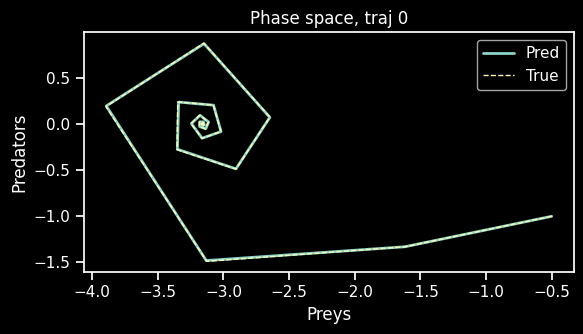

In [ ]:
# %%

def test_model(params, static, batch):
    X0, t = batch
    rhs = eqx.combine(params, static)

    X_hat = integrator(rhs, X0, t, 1.4e-8, 1.4e-8, jnp.inf, jnp.inf, 50, "checkpointed")

    return X_hat


i = np.random.randint(0, 1)

X = data[0, i, :, :]
t = t_eval

X_hat = test_model(params, static, (X[0,:], t))

ax = sbplot(X_hat[:,0], X_hat[:,1], x_label='Preys', y_label='Predators', label=f'Pred', title=f'Phase space, traj {i}')
ax = sbplot(X[:,0], X[:,1], "--", lw=1, label=f'True', ax=ax)

# plt.savefig(f"data/coda_test_env{e}_traj{i}.png", dpi=300, bbox_inches='tight')
plt.savefig(f"data/test_simple.png", dpi=300, bbox_inches='tight')

In [ ]:
#%% 

model = eqx.combine(params, static)

eqx.tree_serialise_leaves("data/model_02.eqx", model)
# model = eqx.tree_deserialise_leaves("data/model_01.eqx", model)

# %% [markdown]

 # Preliminary results
 - Nothing yet
 # Conclusion



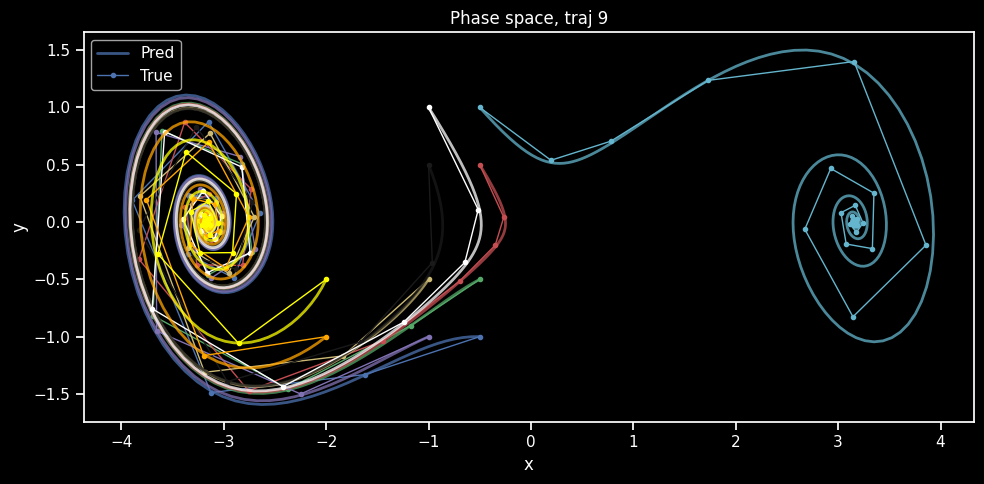

In [ ]:
# %%

def test_model(params, static, batch):
    X0, t = batch
    rhs = eqx.combine(params, static)

    X_hat = jax.vmap(integrator, in_axes=(None, 0, None, None, None, None, None, None, None)
                     )(rhs, X0, t, 1.4e-8, 1.4e-8, jnp.inf, jnp.inf, 50, "checkpointed")
    # X_hat = integrator(rhs, X0, t, 1.4e-8, 1.4e-8, jnp.inf, jnp.inf, 50, "checkpointed")

    return X_hat


i = np.random.randint(0, 1)

X = data[0, :10, :, :]
t = np.linspace(t_span[0], t_span[1], 500)

X_hat = test_model(params, static, (X[:, 0,:], t))

fig, ax = plt.subplots(1, 1, figsize=(10, 5))



colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'orange', 'yellow', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

for i in range(X.shape[0]):
#     if i==0:
#         ax = sbplot(t, X_hat[i, :, 0], x_label='Time', y_label='Displacement', label=f'Pred', title=f'Trajectory {i}', ax=ax)
#         ax = sbplot(t, X[i, :, 0], "--", lw=1, label=f'True', ax=ax)
#     else:
#         ax = sbplot(t, X_hat[i, :, 0], x_label='Time', y_label='Displacement', title=f'Trajectory {i}', ax=ax)
#         ax = sbplot(t, X[i, :, 0], "--", lw=1, ax=ax)

    if i==0:
        sbplot(X_hat[i, :,0], X_hat[i, :,1], x_label='x', y_label='y', label=f'Pred', title=f'Phase space, traj {i}', ax=ax, alpha=0.75, color=colors[i])
        sbplot(X[i, :,0], X[i, :,1], ".-", lw=1, label=f'True', ax=ax, color=colors[i])
    else:
        sbplot(X_hat[i, :,0], X_hat[i, :,1], x_label='x', y_label='y', title=f'Phase space, traj {i}', ax=ax, alpha=0.75, color=colors[i])
        sbplot(X[i, :,0], X[i, :,1], ".-", lw=1, ax=ax, color=colors[i])

# plt.savefig(f"data/coda_test_env{e}_traj{i}.png", dpi=300, bbox_inches='tight')
plt.savefig(f"data/test_simple.png", dpi=300, bbox_inches='tight')